# Alireza KHODABAKHSH
 https://github.com/alirezakhodabakhsh
 

# Lib

In [1]:
import torch
torch.manual_seed(42)
from torch import nn
import random
random.seed(42)
from CustomDataset import ECGDataset, ECG_Normalize
from torch.utils.data import random_split
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.nn.modules.module import _addindent

# Helper

In [2]:
def evaluate_classifier(model, dataloader, criterion, device='cpu'):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs, labels = inputs.float(), labels.long()
            inputs = torch.unsqueeze(inputs, 1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss = running_loss / len(dataloader)
    val_acc = 100. * correct / total
    return val_loss, val_acc

In [3]:
def plot_training_history(epochs, train_losses, train_accuracies, val_losses, val_accuracies):
    """
    Plots the training and validation loss and accuracy up to the current epoch.
    """
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Hyper

In [17]:
device = 'cuda'
# ARGS
length_channels = 187
num_channels = 1

num_epochs=10
learning_rate = 0.005
save_path="best_ECGNet_model.pth"

# Data

In [ ]:
# Dataset Link
"https://www.kaggle.com/datasets/shayanfazeli/heartbeat/data?select=ptbdb_normal.csv"

In [18]:
import numpy as np
from torch.utils.data import DataLoader, random_split

# Assuming ECGDataset and data_loaders are defined elsewhere
normalize_transform = ECG_Normalize()

# Create the full dataset
full_dataset = ECGDataset("D:\\GitHub\\TimeEntropyNN\\Dataset\\ECG_Kaggle\\PTBDB", transform=normalize_transform)

# Shuffle dataset indices
dataset_size = len(full_dataset)
indices = list(range(dataset_size))
np.random.shuffle(indices)

# Optionally: Stratify split your dataset here if needed

# Calculate sizes for train, validation, and test sets
train_size = int(0.6 * dataset_size)
val_size = int(0.2 * dataset_size)
test_size = dataset_size - train_size - val_size

# Split the dataset according to the shuffled indices
train_indices, val_indices, test_indices = indices[:train_size], indices[train_size:train_size+val_size], indices[train_size+val_size:]

train_dataset = torch.utils.data.Subset(full_dataset, train_indices)
val_dataset = torch.utils.data.Subset(full_dataset, val_indices)
test_dataset = torch.utils.data.Subset(full_dataset, test_indices)

# Create dataloaders
batch_size = 128
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Network

In [ ]:
class Conv2dWithConstraint(nn.Conv2d):
    def __init__(self, *args, max_norm=1, **kwargs):
        self.max_norm = max_norm
        super(Conv2dWithConstraint, self).__init__(*args, **kwargs)

    def forward(self, x):
        self.weight.data = torch.renorm(
            self.weight.data, p=2, dim=0, maxnorm=self.max_norm
        )
        return super(Conv2dWithConstraint, self).forward(x)

In [ ]:
class ECGNet(nn.Module):
    def InitialBlocks(self, dropoutRate, *args, **kwargs):
        block1 = nn.Sequential(
            nn.Conv2d(1, self.F1, (1, self.kernelLength), stride=1, padding=(0, self.kernelLength // 2), bias=False),
            nn.BatchNorm2d(self.F1, momentum=0.01, affine=True, eps=1e-3),

            # DepthwiseConv2D =======================
            Conv2dWithConstraint(self.F1, self.F1 * self.D, (self.channels, 1), max_norm=1, stride=1, padding=(0, 0),
                                 groups=self.F1, bias=False),
            # ========================================

            nn.BatchNorm2d(self.F1 * self.D, momentum=0.01, affine=True, eps=1e-3),
            nn.ELU(),
            nn.AvgPool2d((1, 4), stride=4),
            nn.Dropout(p=dropoutRate))
        block2 = nn.Sequential(
            # SeparableConv2D =======================
            nn.Conv2d(self.F1 * self.D, self.F1 * self.D, (1, self.kernelLength2), stride=1,
                      padding=(0, self.kernelLength2 // 2), bias=False, groups=self.F1 * self.D),
            nn.Conv2d(self.F1 * self.D, self.F2, 1, padding=(0, 0), groups=1, bias=False, stride=1),
            # ========================================

            nn.BatchNorm2d(self.F2, momentum=0.01, affine=True, eps=1e-3),
            nn.ELU(),
            nn.AvgPool2d((1, 8), stride=8),
            nn.Dropout(p=dropoutRate))
        return nn.Sequential(block1, block2)


    def ClassifierBlock(self, inputSize, n_classes):
        return nn.Sequential(
            nn.Linear(inputSize, n_classes, bias=False),
            nn.Softmax(dim=1))

    def CalculateOutSize(self, model, channels, samples):
        '''
        Calculate the output based on input size.
        model is from nn.Module and inputSize is a array.
        '''
        data = torch.rand(1, 1, channels, samples)
        model.eval()
        out = model(data).shape
        return out[2:]

    def __init__(self, n_classes=4, channels=60, samples=151,
                 dropoutRate=0.5, kernelLength=64, kernelLength2=16, F1=8,
                 D=2, F2=16):
        super(ECGNet, self).__init__()
        self.F1 = F1
        self.F2 = F2
        self.D = D
        self.samples = samples
        self.n_classes = n_classes
        self.channels = channels
        self.kernelLength = kernelLength
        self.kernelLength2 = kernelLength2
        self.dropoutRate = dropoutRate

        self.blocks = self.InitialBlocks(dropoutRate)
        self.blockOutputSize = self.CalculateOutSize(self.blocks, channels, samples)
        self.classifierBlock = self.ClassifierBlock(self.F2 * self.blockOutputSize[1], n_classes)

    def forward(self, x):
        x = self.blocks(x)
        x = x.view(x.size()[0], -1)  # Flatten
        x = self.classifierBlock(x)

        return x

def categorical_cross_entropy(y_pred, y_true):
    # y_pred = y_pred.cuda()
    # y_true = y_true.cuda()
    y_pred = torch.clamp(y_pred, 1e-9, 1 - 1e-9)
    return -(y_true * torch.log(y_pred)).sum(dim=1).mean()

def torch_summarize(model, show_weights=True, show_parameters=True):
    """Summarizes torch model by showing trainable parameters and weights."""
    tmpstr = model.__class__.__name__ + ' (\n'
    for key, module in model._modules.items():
        # if it contains layers let call it recursively to get params and weights
        if type(module) in [
            torch.nn.modules.container.Container,
            torch.nn.modules.container.Sequential
        ]:
            modstr = torch_summarize(module)
        else:
            modstr = module.__repr__()
        modstr = _addindent(modstr, 2)

        params = sum([np.prod(p.size()) for p in module.parameters()])
        weights = tuple([tuple(p.size()) for p in module.parameters()])

        tmpstr += '  (' + key + '): ' + modstr
        if show_weights:
            tmpstr += ', weights={}'.format(weights)
        if show_parameters:
            tmpstr +=  ', parameters={}'.format(params)
        tmpstr += '\n'

    tmpstr = tmpstr + ')'
    return tmpstr

# Train

In [19]:
len(train_dataset)
model = ECGNet(n_classes=2, channels=1, samples=length_channels, dropoutRate=0, 
                      kernelLength=64, kernelLength2=16, F1=8, D=2, F2=16).to(device)

#model.apply(lambda m: utils.custom_normal_weights_init(m, mean=0.0, variance=0.1))

print("#P_ECGNet : ", sum(p.numel() for p in model.parameters() if p.requires_grad))

#P_EEGNet :  1312


# SOlve Imlabance data

In [20]:
n1 = len([label for label in full_dataset.labels if label == 0])
n2 = len([label for label in full_dataset.labels if label == 1])
total = n1 + n2

weight_for_class_0 = total / (2.0 * n1)
weight_for_class_1 = total / (2.0 * n2)
weights = torch.tensor([weight_for_class_0, weight_for_class_1], dtype=torch.float)

# Move weights to the same device as your model
weights = weights.to(device)

In [21]:
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss(weight=weights)
best_val_loss = float('inf')
epochs, train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], [], []

In [22]:
model

EEGNet(
  (blocks): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 8, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32), bias=False)
      (1): BatchNorm2d(8, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Conv2dWithConstraint(8, 16, kernel_size=(1, 1), stride=(1, 1), groups=8, bias=False)
      (3): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (4): ELU(alpha=1.0)
      (5): AvgPool2d(kernel_size=(1, 4), stride=4, padding=0)
      (6): Dropout(p=0, inplace=False)
    )
    (1): Sequential(
      (0): Conv2d(16, 16, kernel_size=(1, 16), stride=(1, 1), padding=(0, 8), groups=16, bias=False)
      (1): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (2): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (3): ELU(alpha=1.0)
      (4): AvgPool2d(kernel_size=(1, 8), stride=8, padding=0)
      (5): Dropout(p=0, inplace=False)
    )
  )
  (classifierBlock): S

In [44]:
init_epoch = 0
num_epochs = 50
learning_rate = 0.005

Epoch: 299 | Train Loss: 0.3456 | Train Acc: 97.17% | Val Loss: 0.3580 | Val Acc: 95.88%


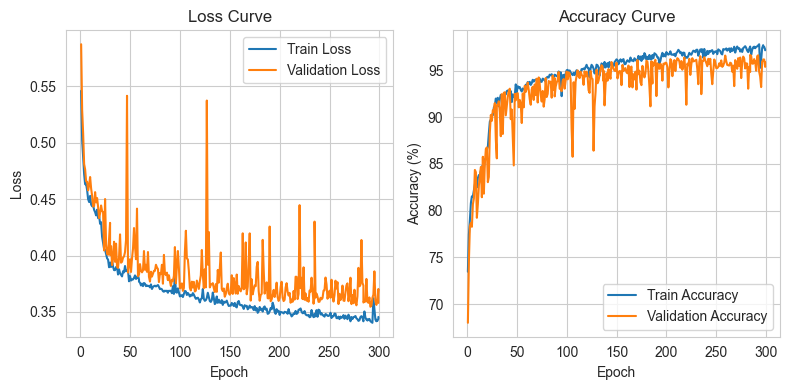

In [45]:
for epoch in range(init_epoch, init_epoch + num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        inputs, labels = inputs.float(), labels.long()
        inputs = torch.unsqueeze(inputs, 1)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_dataloader)
    train_acc = 100. * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Evaluate on validation set
    val_loss, val_acc = evaluate_classifier(model, val_dataloader, criterion, device=device)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    epochs.append(epoch + 1)

    print(f"Epoch: {epoch+1} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    # Save the best model based on validation accuracy
    if val_loss < best_val_loss:
        print("Validation loss improved. Saving the model...")
        torch.save(model.state_dict(), save_path)
        best_val_loss = val_loss
    
    plot_training_history(epochs, train_losses, train_accuracies, val_losses, val_accuracies)


# Test

In [46]:
# Evaluate on validation set
test_loss, test_acc = evaluate_classifier(model, test_dataloader, criterion, device=device)


print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")

Test Loss: 0.3589 | Test Acc: 96.26%


# END